In [2]:
!pip uninstall -y tensorflow tensorflow-cpu tensorflow-intel
!pip install tensorflow==2.17.1




Found existing installation: tensorflow 2.17.1
Uninstalling tensorflow-2.17.1:
  Successfully uninstalled tensorflow-2.17.1
Found existing installation: tensorflow-intel 2.17.1
Uninstalling tensorflow-intel-2.17.1:
  Successfully uninstalled tensorflow-intel-2.17.1


  Using cached tensorflow-2.17.1-cp310-cp310-win_amd64.whl.metadata (3.3 kB)
  Using cached tensorflow_intel-2.17.1-cp310-cp310-win_amd64.whl.metadata (5.0 kB)
Using cached tensorflow-2.17.1-cp310-cp310-win_amd64.whl (7.5 kB)
Using cached tensorflow_intel-2.17.1-cp310-cp310-win_amd64.whl (382.2 MB)

   ---------------------------------------- 0/2 [tensorflow-intel]
   ---------------------------------------- 0/2 [tensorflow-intel]
   ---------------------------------------- 0/2 [tensorflow-intel]
   ---------------------------------------- 0/2 [tensorflow-intel]
   ---------------------------------------- 0/2 [tensorflow-intel]
   ---------------------------------------- 0/2 [tensorflow-intel]
   ---------------------------------------- 0/2 [tensorflow-intel]
   ---------------------------------------- 0/2 [tensorflow-intel]
   ---------------------------------------- 0/2 [tensorflow-intel]
   ---------------------------------------- 0/2 [tensorflow-intel]
   --------------------------

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import os


ModuleNotFoundError: No module named 'tensorflow_datasets'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = "/content/drive/MyDrive/medical-diagnosis/images"


In [ ]:
dataset_path = "/content/drive/MyDrive/medical-diagnosis/images"

img_size = (256, 256)
batch_size = 32

train_ds = keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
print("CLASSES:", class_names)



Found 5400 files belonging to 6 classes.
Using 4320 files for training.
Found 5400 files belonging to 6 classes.
Using 1080 files for validation.
CLASSES: ['brain_glioma', 'brain_meningioma', 'brain_normal', 'brain_pituitary', 'chest_normal', 'chest_pneumonia']


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)


In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


In [ ]:
base_model = keras.applications.EfficientNetV2B0(
    include_top=False,
    input_shape=(256, 256, 3),
    weights="imagenet"
)

base_model.trainable = False


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
inputs = keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = keras.applications.efficientnet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 8, 8, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,926,998 (22.61 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,   # ← Reduced from 50 to 20
    callbacks=[early_stop, checkpoint]
)


Epoch 1/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3642 - loss: 1.5526
Epoch 1: val_accuracy improved from -inf to 0.63889, saving model to best_model.keras
135/135 ━━━━━━━━━━━━━━━━━━━━ 729s 5s/step - accuracy: 0.3647 - loss: 1.5515 - val_accuracy: 0.6389 - val_loss: 1.0907
Epoch 2/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5583 - loss: 1.1203
Epoch 2: val_accuracy improved from 0.63889 to 0.72222, saving model to best_model.keras
135/135 ━━━━━━━━━━━━━━━━━━━━ 406s 3s/step - accuracy: 0.5585 - loss: 1.1200 - val_accuracy: 0.7222 - val_loss: 0.9074
Epoch 3/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6419 - loss: 0.9524
Epoch 3: val_accuracy improved from 0.72222 to 0.75741, saving model to best_model.keras
135/135 ━━━━━━━━━━━━━━━━━━━━ 436s 3s/step - accuracy: 0.6418 - loss: 0.9523 - val_accuracy: 0.7574 - val_loss: 0.7951
Epoch 4/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7001 - loss: 0.8502
Epoch 4: val_accuracy improved from 0.7574

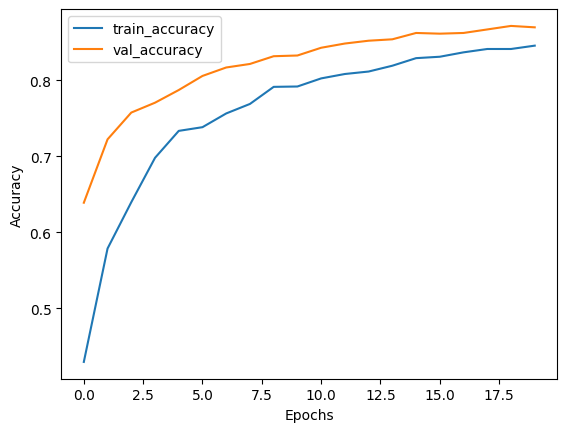

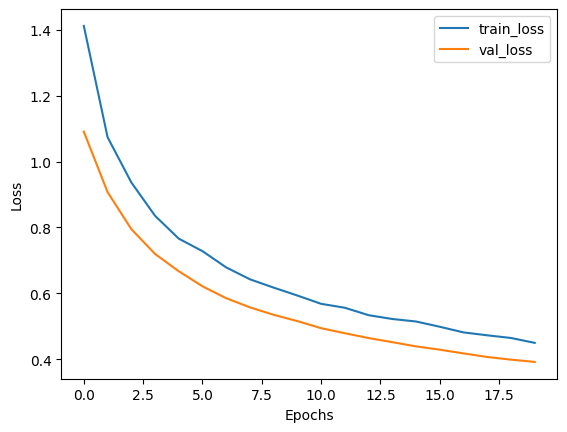

In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print("Final Train Accuracy:", final_train_acc)
print("Final Validation Accuracy:", final_val_acc)


Final Train Accuracy: 0.845370352268219
Final Validation Accuracy: 0.8694444298744202


In [ ]:
from tensorflow.keras.models import load_model

best_model = load_model("best_model.keras")


In [ ]:
loss, acc = best_model.evaluate(val_ds)
print(f"Best Model Validation Accuracy: {acc*100:.2f}%")


34/34 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.8656 - loss: 0.3861
Best Model Validation Accuracy: 87.13%


In [ ]:
best_model.export("saved_model")



Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_layer_1')]
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  133240007223312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133240007224272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133242447998288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133239966415952: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  133239966415760: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  133239966415184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133239966416528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133239966416336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133239966414608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133239966414800: TensorSpec(shape=(), dtype=tf.resource, name=No

In [ ]:
from tensorflow.keras.models import load_model

best_model = load_model("best_model.keras")

# Export for Vertex AI
best_model.export("saved_model")


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_layer_1')]
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  133237407120848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133237407120464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133237407121040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133237407119120: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  133237407119312: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  133237407120272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133237407120656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133237407118928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133237407118160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133237407117584: TensorSpec(shape=(), dtype=tf.resource, name=No

In [ ]:
import os

os.listdir(".")



['.config', 'converted_tflite (1).zip', 'saved_model.zip', 'sample_data']

In [ ]:
!unzip saved_model.zip


Archive:  saved_model.zip
   creating: saved_model/
   creating: saved_model/assets/
   creating: saved_model/variables/
  inflating: saved_model/variables/variables.data-00000-of-00001  
  inflating: saved_model/variables/variables.index  
  inflating: saved_model/saved_model.pb  
 extracting: saved_model/fingerprint.pb  


In [ ]:
import os
os.listdir(".")


['.config',
 'converted_tflite (1).zip',
 'saved_model',
 'saved_model.zip',
 'sample_data']

In [ ]:
os.listdir("saved_model")


['assets', 'variables', 'saved_model.pb', 'fingerprint.pb']

In [ ]:
!zip -r saved_model.zip saved_model/


  adding: saved_model/ (stored 0%)
  adding: saved_model/assets/ (stored 0%)
  adding: saved_model/variables/ (stored 0%)
  adding: saved_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: saved_model/variables/variables.index (deflated 78%)
  adding: saved_model/saved_model.pb (deflated 91%)
  adding: saved_model/fingerprint.pb (stored 0%)


In [ ]:
import tensorflow as tf
from keras.layers import TFSMLayer
from keras.models import Sequential

model = Sequential([
    TFSMLayer(
        "saved_model",
        call_endpoint="serving_default"
    )
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tfsm_layer_3 (TFSMLayer)        │ ?                      │     5,927,004 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,927,004 (22.61 MB)

 Trainable params: 5,866,390 (22.38 MB)

 Non-trainable params: 60,614 (236.80 KB)

In [ ]:
import tensorflow as tf
import numpy as np
from keras.layers import TFSMLayer, Input
from keras.models import Model
from tensorflow.keras.preprocessing import image

# Define class labels
class_names = [
    "brain_glioma",
    "brain_meningioma",
    "brain_normal",
    "brain_pituitary",
    "chest_normal",
    "chest_pneumonia"
]

# Input must match training shape
inputs = Input(shape=(256, 256, 3))

# Load SavedModel
tfsm_layer = TFSMLayer(
    "saved_model",
    call_endpoint="serving_default"
)

outputs = tfsm_layer(inputs)

# Build model
model = Model(inputs, outputs)
model.summary()

# Load and preprocess image
img = image.load_img("sample_test.jpg", target_size=(256, 256))
img = image.img_to_array(img) / 255.0
img = np.expand_dims(img, axis=0)

# Predict (extract tensor from dict)
pred = model.predict(img)["output_0"]

predicted_class = class_names[np.argmax(pred)]
confidence = round(float(np.max(pred)) * 100, 2)

print("Predicted:", predicted_class)
print("Confidence:", confidence, "%")



Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tfsm_layer_7 (TFSMLayer)        │ (None, 6)              │     5,927,004 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,927,004 (22.61 MB)

 Trainable params: 5,866,390 (22.38 MB)

 Non-trainable params: 60,614 (236.80 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted: brain_glioma
Confidence: 42.95 %


In [ ]:
!pip install google-cloud-aiplatform


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 27.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.8
    Uninstalling protobuf-4.25.8:
      Successfully uninstalled protobuf-4.25.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.17.1 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 5.29.5 which is incompatible.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.17.1 which is incompatible.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.17.1 which is incompatible.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.17.1 which is incompatible.


In [ ]:
from google.cloud import aiplatform
import os


In [ ]:
from google.cloud import aiplatform
import numpy as np
from tensorflow.keras.preprocessing import image

# Set GCP environment
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/path/to/your/service-account.json"

# Initialize Vertex AI
PROJECT_ID = "medical-diagnosis-0806"
REGION = "us-central1"
ENDPOINT_ID = "599672542277402624"

aiplatform.init(project=PROJECT_ID, location=REGION)

# Get endpoint
endpoint = aiplatform.Endpoint(endpoint_name=ENDPOINT_ID)

# Load & preprocess image
img_path = "sample_test.jpg"
img = image.load_img(img_path, target_size=(256, 256))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Convert to list for JSON payload
payload = img_array.tolist()

# Make prediction request
prediction = endpoint.predict(instances=payload)

# The prediction result
print(prediction)

# Map to your classes
class_names = [
    "brain_glioma",
    "brain_meningioma",
    "brain_normal",
    "brain_pituitary",
    "chest_normal",
    "chest_pneumonia"
]

predicted_class = class_names[np.argmax(prediction.predictions[0])]
confidence = max(prediction.predictions[0]) * 100

print("Predicted:", predicted_class)
print("Confidence:", round(confidence, 2), "%")


DefaultCredentialsError: File /path/to/your/service-account.json was not found.